Aspect-Based Sentiment Analysis

In [41]:
# Εισαγωγή απαραίτητων βιβλιοθηκών
import os
os.environ["TF_USE_LEGACY_KERAS"] = "1"  # Χρήση legacy Keras API
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"  # Απενεργοποίηση oneDNN optimizations

import numpy as np  # Βιβλιοθήκη για αριθμητικές πράξεις
import pandas as pd  # Βιβλιοθήκη για επεξεργασία δεδομένων
import seaborn as sns  # Βιβλιοθήκη για στατιστικά γραφήματα
import warnings  # Διαχείριση προειδοποιήσεων
warnings.filterwarnings("ignore")  # Αγνόηση προειδοποιήσεων
import plotly.graph_objects as go  # Διαδραστικά γραφήματα
import matplotlib.pyplot as plt  # Βιβλιοθήκη για γραφήματα
import spacy  # Βιβλιοθήκη για επεξεργασία φυσικής γλώσσας
import tensorflow as tf  # Βιβλιοθήκη για βαθιά μάθηση
import ktrain  # Βιβλιοθήκη για ευκολότερη χρήση μοντέλων TensorFlow και Keras
from ktrain import text  # Εργαλεία κειμένου από τη βιβλιοθήκη ktrain
from sklearn.decomposition import PCA  # Ανάλυση Κύριων Συνιστωσών (PCA)

from collections import Counter  # Βιβλιοθήκη για συλλογές δεδομένων
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer  # Μετατροπή κειμένου σε χαρακτηριστικά
from sklearn.decomposition import LatentDirichletAllocation  # Κατανομή Λανθανόντων Δεικτών (LDA)
from sklearn.model_selection import train_test_split, GridSearchCV  # Διαχωρισμός δεδομένων και αναζήτηση παραμέτρων
from sklearn.svm import SVC  # Υποστήριξη Μηχανών Διανυσμάτων (SVM)
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix  # Αξιολόγηση μοντέλων

import nltk  # Βιβλιοθήκη για επεξεργασία φυσικής γλώσσας
nltk.download('punkt')  # Λήψη tokenizer
nltk.download('stopwords')  # Λήψη stopwords
nltk.download('wordnet')  # Λήψη λεξιλογίου WordNet

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\kkmar_ymr3ruz\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kkmar_ymr3ruz\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\kkmar_ymr3ruz\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [42]:
# Φόρτωση συνόλου δεδομένων
df = pd.read_csv('50_tripadvisor_hotel_reviews.csv')

# Εμφάνιση σχήματος συνόλου δεδομένων και πρώτων γραμμών
print("Dataset shape:", df.shape)
print(df.head())

Dataset shape: (199, 2)
                                              Review  Rating
0  nice hotel expensive parking got good deal sta...       4
1  ok nothing special charge diamond member hilto...       2
2  nice rooms not 4* experience hotel monaco seat...       3
3  unique, great stay, wonderful time hotel monac...       5
4  great stay great stay, went seahawk game aweso...       5


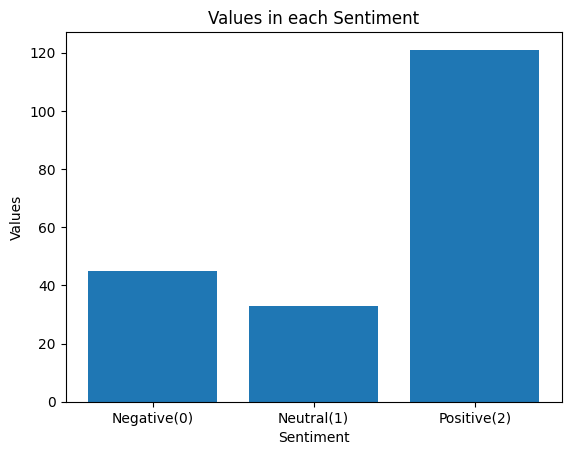

In [43]:
# Ορισμός ετικετών συναισθήματος
pos = [4, 5]  # Θετικές βαθμολογίες
neg = [1, 2]  # Αρνητικές βαθμολογίες
neu = [3]  # Ουδέτερες βαθμολογίες

# Συνάρτηση για μετατροπή βαθμολογίας σε κατηγορία συναισθήματος
def sentiment(rating):
    if rating in pos:
        return 2  # Θετικό
    elif rating in neg:
        return 0  # Αρνητικό
    else:
        return 1  # Ουδέτερο

# Εφαρμογή συνάρτησης συναισθήματος στο σύνολο δεδομένων
df['Sentiment'] = df['Rating'].apply(sentiment)

# Οπτικοποίηση κατανομής συναισθήματος
sentiment_counts = df['Sentiment'].value_counts().sort_index()

plt.bar(sentiment_counts.index, sentiment_counts.values)
plt.title("Values in each Sentiment")
plt.xlabel("Sentiment")
plt.ylabel("Values")
plt.xticks(sentiment_counts.index, ["Negative(0)", "Neutral(1)", "Positive(2)"])  # Ετικέτες συναισθημάτων
plt.show()

In [44]:
# Λήψη και φόρτωση μοντέλου SpaCy
spacy.cli.download("en_core_web_sm")
nlp = spacy.load('en_core_web_sm')

# Συνάρτηση κανονικοποίησης κειμένου
def normalize(msg):
    doc = nlp(msg)
    res = [token.lemma_.lower() for token in doc if not (token.is_stop or token.is_punct or token.is_space)]
    return res  

# Εφαρμογή κανονικοποίησης στις κριτικές
df['Review'] = df['Review'].apply(normalize)

# Εμφάνιση κανονικοποιημένων κριτικών
print(df.head())

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
                                              Review  Rating  Sentiment
0  [nice, hotel, expensive, parking, get, good, d...       4          2
1  [ok, special, charge, diamond, member, hilton,...       2          0
2  [nice, room, 4, experience, hotel, monaco, sea...       3          1
3  [unique, great, stay, wonderful, time, hotel, ...       5          2
4  [great, stay, great, stay, go, seahawk, game, ...       5          2


In [45]:
# Συνάρτηση δημιουργίας πίνακα συχνότητας λέξεων
def create_freq_table(data):
    words_collection = Counter([item for sublist in data for item in sublist])
    freq_word_df = pd.DataFrame(words_collection.most_common(15))
    freq_word_df.columns = ['frequently_used_word', 'count']
    return freq_word_df

# Πίνακες συχνότητας λέξεων για κάθε συναισθηματική κατηγορία
freq_all = create_freq_table(df['Review'].tolist())
freq_pos = create_freq_table(df[df['Sentiment'] == 2]['Review'].tolist())
freq_neu = create_freq_table(df[df['Sentiment'] == 1]['Review'].tolist())
freq_neg = create_freq_table(df[df['Sentiment'] == 0]['Review'].tolist())

# Συνδυασμός όλων των συχνά χρησιμοποιούμενων λέξεων σε ένα σύνολο
frequent_words = set(freq_all['frequently_used_word']).union(set(freq_pos['frequently_used_word'])).union(set(freq_neu['frequently_used_word'])).union(set(freq_neg['frequently_used_word']))

# Δημιουργία νέων χαρακτηριστικών βασισμένων στην παρουσία αυτών των λέξεων
for word in frequent_words:
    df[word] = df['Review'].apply(lambda x: 1 if word in x else 0)


APPLY LDA FOR TOPIC MODELING

In [46]:
# Μετατροπή κριτικών σε ενιαίο string για κάθε κριτική
vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
df['Review_Joined'] = df['Review'].apply(lambda x: ' '.join(x))
dtm = vectorizer.fit_transform(df['Review_Joined'])

# Εφαρμογή Latent Dirichlet Allocation για θεματολογική μοντελοποίηση
lda = LatentDirichletAllocation(n_components=10, random_state=42)
lda.fit(dtm)

# Μετατροπή εγγράφων σε κατανομές θεμάτων
topic_distributions = lda.transform(dtm)

# Εφαρμογή PCA για μείωση διαστάσεων
pca = PCA(n_components=10)
topic_distributions_pca = pca.fit_transform(topic_distributions)

# Συνδυασμός κατανομών θεμάτων LDA και χαρακτηριστικών συχνότητας
X = np.hstack((topic_distributions_pca, df[list(frequent_words)]))


SVM MODEL

In [47]:
# Προετοιμασία δεδομένων για μοντέλο SVM
y = df['Sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Συνάρτηση για εκπαίδευση μοντέλου SVM με αναζήτηση παραμέτρων
def train_svm(X_train, y_train):
    # Αναζήτηση παραμέτρων
    parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10, 100]}
    svm = GridSearchCV(SVC(), parameters, cv=5)
    svm.fit(X_train, y_train)
    
    return svm

# Εκπαίδευση μοντέλου SVM
svm_model = train_svm(X_train, y_train)


In [48]:
# Αξιολόγηση του μοντέλου SVM
X_test_predictions = svm_model.predict(X_test)
print("SVM Classification Report:")
print(classification_report(y_test, X_test_predictions))
print("SVM Accuracy Score:", accuracy_score(y_test, X_test_predictions))
print("SVM Confusion Matrix:\n", confusion_matrix(y_test, X_test_predictions))


SVM Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.25      0.40        12
           1       1.00      0.33      0.50         3
           2       0.69      1.00      0.82        25

    accuracy                           0.72        40
   macro avg       0.90      0.53      0.57        40
weighted avg       0.81      0.72      0.67        40

SVM Accuracy Score: 0.725
SVM Confusion Matrix:
 [[ 3  0  9]
 [ 0  1  2]
 [ 0  0 25]]


BERT MODEL

In [49]:
# Προετοιμασία δεδομένων για μοντέλο BERT
df['Review'] = df['Review_Joined']
(x_train, y_train), (x_test, y_test), preproc = text.texts_from_df(df, 'Review', label_columns=['Sentiment'], preprocess_mode='bert')

['Sentiment_0', 'Sentiment_1', 'Sentiment_2']
     Sentiment_0  Sentiment_1  Sentiment_2
92           1.0          0.0          0.0
171          0.0          1.0          0.0
76           1.0          0.0          0.0
131          0.0          0.0          1.0
31           0.0          0.0          1.0
['Sentiment_0', 'Sentiment_1', 'Sentiment_2']
     Sentiment_0  Sentiment_1  Sentiment_2
69           1.0          0.0          0.0
39           0.0          0.0          1.0
143          0.0          0.0          1.0
130          0.0          1.0          0.0
59           0.0          0.0          1.0
preprocessing train...
language: en


Is Multi-Label? False
preprocessing test...
language: en


In [50]:
# Δημιουργία και εκπαίδευση μοντέλου BERT
model = text.text_classifier(name='bert', train_data=(x_train, y_train), preproc=preproc)
learner = ktrain.get_learner(model=model, train_data=(x_train, y_train), val_data=(x_test, y_test), batch_size=6)
learner.fit_onecycle(lr=2e-5, epochs=3)  # Αυξημένος αριθμός epochs για βελτίωση της εκπαίδευσης

Is Multi-Label? False
maxlen is 400
done.


begin training using onecycle policy with max lr of 2e-05...
Epoch 1/3
30/30 [==============================] - 135s 4s/step - loss: 0.9125 - accuracy: 0.6089 - val_loss: 0.8457 - val_accuracy: 0.6000
Epoch 2/3
30/30 [==============================] - 117s 4s/step - loss: 0.6613 - accuracy: 0.7542 - val_loss: 0.6472 - val_accuracy: 0.8500
Epoch 3/3
30/30 [==============================] - 117s 4s/step - loss: 0.4513 - accuracy: 0.8492 - val_loss: 0.5691 - val_accuracy: 0.8000


In [51]:
# Αξιολόγηση του μοντέλου BERT
learner.validate(val_data=(x_test, y_test))

1/1 [==============================] - 7s 7s/step
              precision    recall  f1-score   support

           0       1.00      0.83      0.91         6
           1       0.00      0.00      0.00         2
           2       0.79      0.92      0.85        12

    accuracy                           0.80        20
   macro avg       0.60      0.58      0.59        20
weighted avg       0.77      0.80      0.78        20



array([[ 5,  0,  1],
       [ 0,  0,  2],
       [ 0,  1, 11]], dtype=int64)